In [29]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [30]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [32]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [33]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [34]:
# View all of the classes that automap found
print(Base.classes.keys())


['measurement', 'station']


In [35]:
# Save references to each table

measurement = Base.classes.measurement
station = Base.classes.station


In [36]:
# Create our session (link) from Python to the DB
session = Session(engine) 


In [37]:
# Get the column names of the measurement table
measurement_columns = measurement.__table__.columns.keys()
print(measurement_columns)


['id', 'station', 'date', 'prcp', 'tobs']


# Exploratory Precipitation Analysis

In [38]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date

'2017-08-23'

<class 'str'>


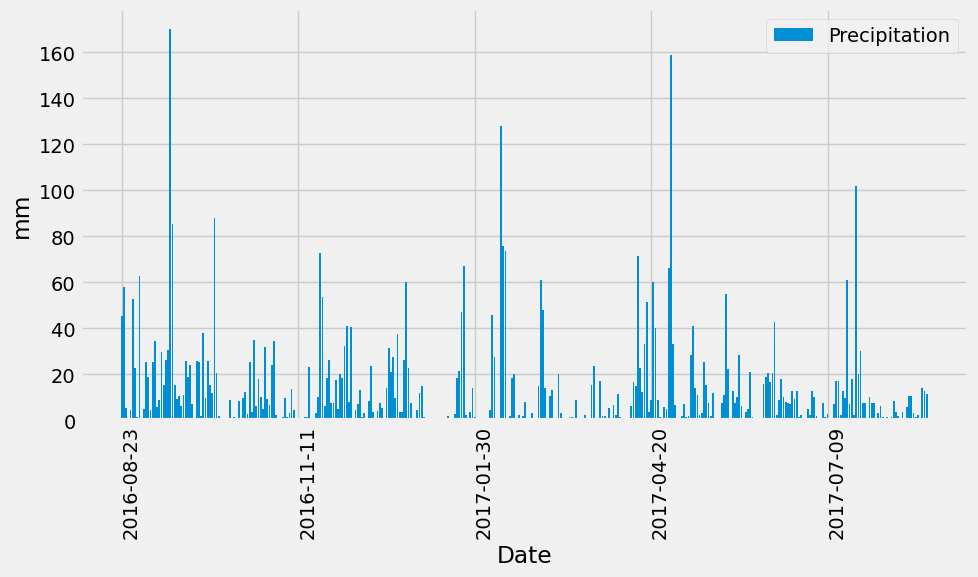

In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date = dt.datetime(int(most_recent_date.split("-")[0]), \
                       int(most_recent_date.split("-")[1]), \
                       int(most_recent_date.split("-")[2]))

# Calculate the date one year from the last date in data set.
start_date = end_date.replace(year=end_date.year - 1).strftime('%Y-%m-%d')
print(type(start_date))
# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(
    measurement.date >= start_date,
    measurement.date <= end_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=["Date", "Precipitation"])

# Sort the dataframe by date
df_sorted = df.sort_values(by="Date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(df_sorted["Date"], df_sorted["Precipitation"], label="Precipitation")
plt.xlabel("Date")
plt.ylabel("mm")

# Set x-axis tick positions and labels
from matplotlib.ticker import MaxNLocator
locator = MaxNLocator(nbins=6)  
plt.gca().xaxis.set_major_locator(locator)
plt.legend()
plt.xticks(rotation=90, ha="left")
plt.tight_layout()
plt.show()

In [40]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df["Precipitation"].describe()

summary_statistics

count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [41]:
station_columns = station.__table__.columns.keys()
print(station_columns)

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [42]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(func.count(station.id)).all()
num_stations

[(9,)]

In [44]:
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

active_stations
# another way to achieve this 
# sorted_active_stations = sorted(active_stations, key=lambda x: x[1], reverse=True)
# sorted_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by((func.count(measurement.station)).desc()).all()

# List the stations and their counts in descending order.
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [46]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperatures = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
temperatures


[(12.2, 29.4, 22.03582251082252)]

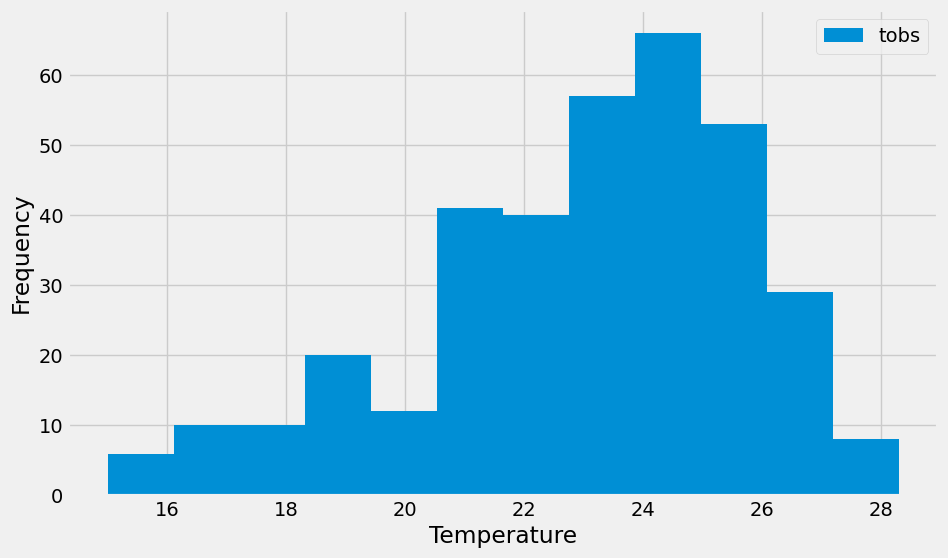

In [47]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temps = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == 'USC00519281',measurement.date >= start_date, measurement.date <= end_date).all()

df1 = pd.DataFrame(last_year_temps, columns=['Date', 'Temperature'])

plt.figure(figsize=(10, 6))
plt.hist(df1['Temperature'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [48]:
# Close Session
session.close()